<a href="https://colab.research.google.com/github/joseph7104/-1INF46-Plan_Compras_Produccion/blob/master/notebooks/EDA_forecast_ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# EDA — Forecast de Ventas (versión alineada a `preprocesamiento (3)`)

Este cuaderno **explora** el dataset final generado por el *pipeline de preprocesamiento más reciente* para el **forecast de ventas**.  
Se asume que el dataset ya integra **ventas + calendario + planificación** y, si corresponde, **clima**.

> **Objetivo**: Verificar estructura, calidad, estacionalidad y relaciones (incluyendo clima, si está disponible) **sin volver a modelar**.


In [1]:
!git clone https://github.com/joseph7104/-1INF46-Plan_Compras_Produccion.git
%cd "./-1INF46-Plan_Compras_Produccion"

Cloning into '-1INF46-Plan_Compras_Produccion'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 99 (delta 18), reused 75 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (99/99), 6.26 MiB | 8.12 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/-1INF46-Plan_Compras_Produccion


## 0) Configuración

In [6]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Configura aquí la ruta del dataset de forecast de ventas ===
# Puede ser la salida del notebook `preprocesamiento (3).ipynb`
DATA_PATH = Path("data/processed/dataset_forecast_diario.csv")  # <-- Ajusta el nombre si es diferente
DATE_COL = "fecha"  # Columna de fecha principal (ajusta si cambió)

# Si el dataset está en memoria en otra variable/archivo, ignora DATA_PATH y carga manualmente más abajo.
print("Ruta configurada:", DATA_PATH)


Ruta configurada: data/processed/dataset_forecast_diario.csv


## 1) Carga del dataset

In [7]:

assert DATA_PATH.exists(), f"No se encontró el archivo en {DATA_PATH}. Cambia DATA_PATH a tu CSV final."
df = pd.read_csv(DATA_PATH)
print("Filas:", len(df), "| Columnas:", len(df.columns))
df.head(3)


Filas: 21410 | Columnas: 42


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos
0,2021-01-15,1,18.0,468.0,2021,1,15,4,0,0,...,21.428571,5.711309,21.214286,5.937865,NaN,NaN,-0.433884,-0.900969,0.0,1.0
1,2021-01-16,1,18.0,468.0,2021,1,16,5,1,0,...,20.000000,5.000000,20.285714,5.268609,NaN,NaN,-0.974928,-0.222521,0.0,1.0
2,2021-01-17,1,32.0,832.0,2021,1,17,6,1,0,...,20.000000,5.000000,20.142857,5.303948,NaN,NaN,-0.781831,0.623490,0.0,1.0


## 2) Inspección de estructura y tipos

In [8]:

display(df.dtypes.to_frame("dtype").T)
display(df.isna().sum().sort_values(ascending=False).head(20).to_frame("n_missing").T)


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos
dtype,object,int64,float64,float64,int64,int64,int64,int64,int64,int64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


,rolling_mean_28,rolling_std_28,lag_28,cantidad,anio,mes,dia,monto_total,fecha,plato,feriado,fin_de_semana,dow,evento_Ano_Nuevo,evento_Dia_del_Pollo_a_la_Brasa,evento_Viernes_Santo,evento_Sabado_Santo,evento_Dia_del_Trabajador,evento_Santa_Rosa_de_Lima,evento_Combate_de_Angamos
n_missing,168,168,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 3) Normalización de fechas y features temporales

In [9]:

# Asegurar que la columna de fecha exista
assert DATE_COL in df.columns, f"No existe la columna de fecha '{DATE_COL}'. Ajusta DATE_COL."

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
if df[DATE_COL].isna().any():
    print("Advertencia: Se encontraron fechas no convertibles. Filtrando nulos en fecha...")
    df = df[~df[DATE_COL].isna()].copy()

df = df.sort_values(DATE_COL).reset_index(drop=True)

# Crear campos temporales si no existen
if "dia_semana" not in df.columns:
    df["dia_semana"] = df[DATE_COL].dt.dayofweek  # 0=Lunes, 6=Domingo
if "mes" not in df.columns:
    df["mes"] = df[DATE_COL].dt.month
if "anio" not in df.columns:
    df["anio"] = df[DATE_COL].dt.year

print("Rango de fechas:", df[DATE_COL].min(), "→", df[DATE_COL].max())
df.head(3)


Rango de fechas: 2021-01-15 00:00:00 → 2025-12-31 00:00:00


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos,dia_semana
0,2021-01-15,1,18.0,468.0,2021,1,15,4,0,0,...,5.711309,21.214286,5.937865,NaN,NaN,-0.433884,-0.900969,0.0,1.0,4
1,2021-01-15,3,17.0,510.0,2021,1,15,4,0,0,...,3.804759,13.714286,4.286447,NaN,NaN,-0.433884,-0.900969,0.0,1.0,4
2,2021-01-15,9,4.0,72.0,2021,1,15,4,0,0,...,1.573592,4.000000,2.183857,NaN,NaN,-0.433884,-0.900969,0.0,1.0,4


## 4) Variables clave (detección automática de nombres)

In [10]:

# Posibles nombres para la variable objetivo (ventas)
TARGET_CANDIDATES = ["ventas", "ventas_total", "venta_total", "y", "target", "ventas_real", "cantidad"]
PLANIF_CANDIDATES = ["planificacion", "ventas_planificadas", "planif_ventas", "plan"]
FERIADO_CANDIDATES = ["feriado", "is_holiday", "es_feriado"]
PLATO_CANDIDATES = ["plato_id", "id_plato", "plato"]

CLIMATE_CANDIDATES = {
    "temp_avg": ["temp_avg", "temperatura_prom", "temp_media"],
    "precip_mm": ["precip_mm", "lluvia_mm", "precipitacion"],
    "humedad": ["humedad", "humedad_rel"],
    "lluvia_flag": ["lluvia_flag", "lluvia", "llueve"],
    "viento_kph": ["viento_kph", "viento", "wind_kph"],
}

def pick_col(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = df.columns.tolist()
target_col = pick_col(TARGET_CANDIDATES, cols)
planif_col = pick_col(PLANIF_CANDIDATES, cols)
feriado_col = pick_col(FERIADO_CANDIDATES, cols)
plato_col = pick_col(PLATO_CANDIDATES, cols)

climate_cols = {}
for key, cands in CLIMATE_CANDIDATES.items():
    col = pick_col(cands, cols)
    if col is not None:
        climate_cols[key] = col

print("Objetivo (ventas):", target_col)
print("Planificación:", planif_col)
print("Feriado:", feriado_col)
print("Columna de plato:", plato_col)
print("Clima detectado:", climate_cols)


Objetivo (ventas): cantidad
Planificación: None
Feriado: feriado
Columna de plato: plato
Clima detectado: {}


## 5) Descriptivo del objetivo (ventas)

In [11]:

assert target_col is not None, "No se encontró una columna objetivo de ventas. Ajusta TARGET_CANDIDATES."
df[target_col].describe()


,cantidad
count,21410.000000
mean,11.488884
std,8.511366
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,56.000000


## 6) Tendencia temporal de ventas

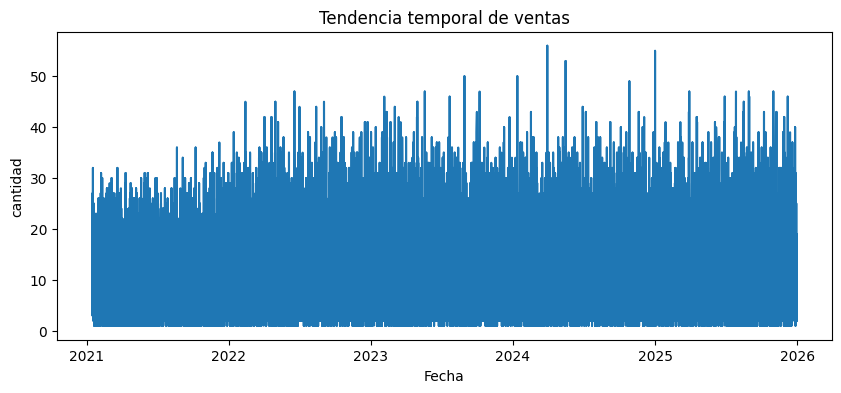

In [12]:

plt.figure(figsize=(10,4))
plt.plot(df[DATE_COL], df[target_col])
plt.title("Tendencia temporal de ventas")
plt.xlabel("Fecha"); plt.ylabel(target_col); plt.show()


## 7) Estacionalidad por día de semana y por mes

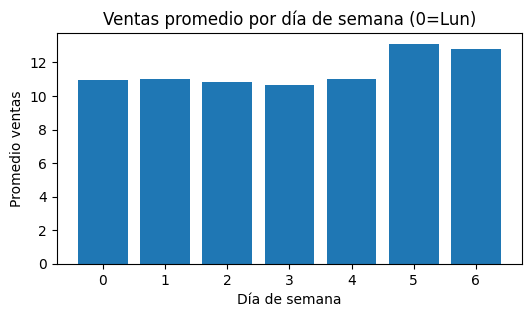

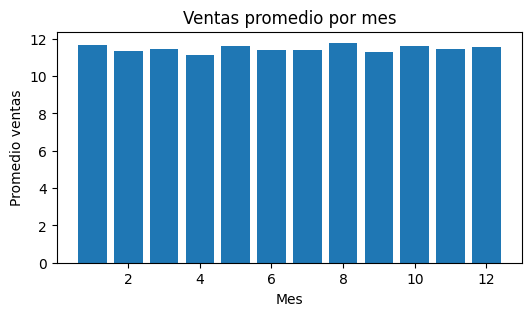

In [13]:

# Por día de semana
by_weekday = df.groupby("dia_semana")[target_col].mean()
plt.figure(figsize=(6,3))
plt.bar(by_weekday.index.astype(int), by_weekday.values)
plt.title("Ventas promedio por día de semana (0=Lun)")
plt.xlabel("Día de semana"); plt.ylabel("Promedio ventas"); plt.show()

# Por mes
by_month = df.groupby("mes")[target_col].mean()
plt.figure(figsize=(6,3))
plt.bar(by_month.index.astype(int), by_month.values)
plt.title("Ventas promedio por mes")
plt.xlabel("Mes"); plt.ylabel("Promedio ventas"); plt.show()


## 8) Correlaciones numéricas (ventas vs. exógenas)

In [14]:

num_like = df.select_dtypes(include=[np.number]).copy()

# Asegurar incluir columnas relevantes si existen
for c in [planif_col, feriado_col]:
    if c and c not in num_like.columns:
        # intentar convertir a numérico si es binaria/categórica
        try:
            num_like[c] = pd.to_numeric(df[c], errors="coerce")
        except Exception:
            pass

for k, c in climate_cols.items():
    if c and c not in num_like.columns:
        try:
            num_like[c] = pd.to_numeric(df[c], errors="coerce")
        except Exception:
            pass

corr_cols = [col for col in [target_col, planif_col, feriado_col] if col is not None]
corr_cols += [c for c in climate_cols.values()]
corr_cols = [c for c in corr_cols if c in num_like.columns]

if len(corr_cols) >= 2:
    corr = num_like[corr_cols].corr()
    display(corr)
else:
    print("No hay suficientes columnas numéricas para correlación (ventas + exógenas).")


,cantidad,feriado
cantidad,1.000000,0.072322
feriado,0.072322,1.000000


## 9) Impacto de feriados (si existe columna)

feriado
No feriado    11.375634
Feriado       14.834522
Name: cantidad, dtype: float64


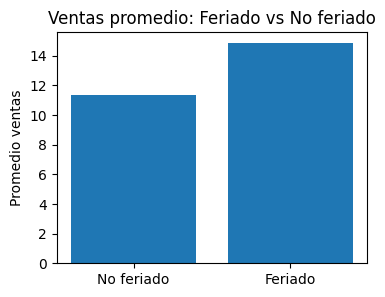

In [15]:

if feriado_col and feriado_col in df.columns:
    # Intentar normalizar a {0,1}
    fer = df[feriado_col]
    if fer.dtype.name == "bool":
        fer_bin = fer.astype(int)
    else:
        fer_bin = pd.to_numeric(fer, errors="coerce").fillna(0).astype(int)
    grp = df.groupby(fer_bin)[target_col].mean().rename(index={0:"No feriado",1:"Feriado"})
    print(grp)
    plt.figure(figsize=(4,3))
    plt.bar(grp.index.astype(str), grp.values)
    plt.title("Ventas promedio: Feriado vs No feriado"); plt.ylabel("Promedio ventas"); plt.show()
else:
    print("No se detectó columna de feriado.")


# **Correlación**

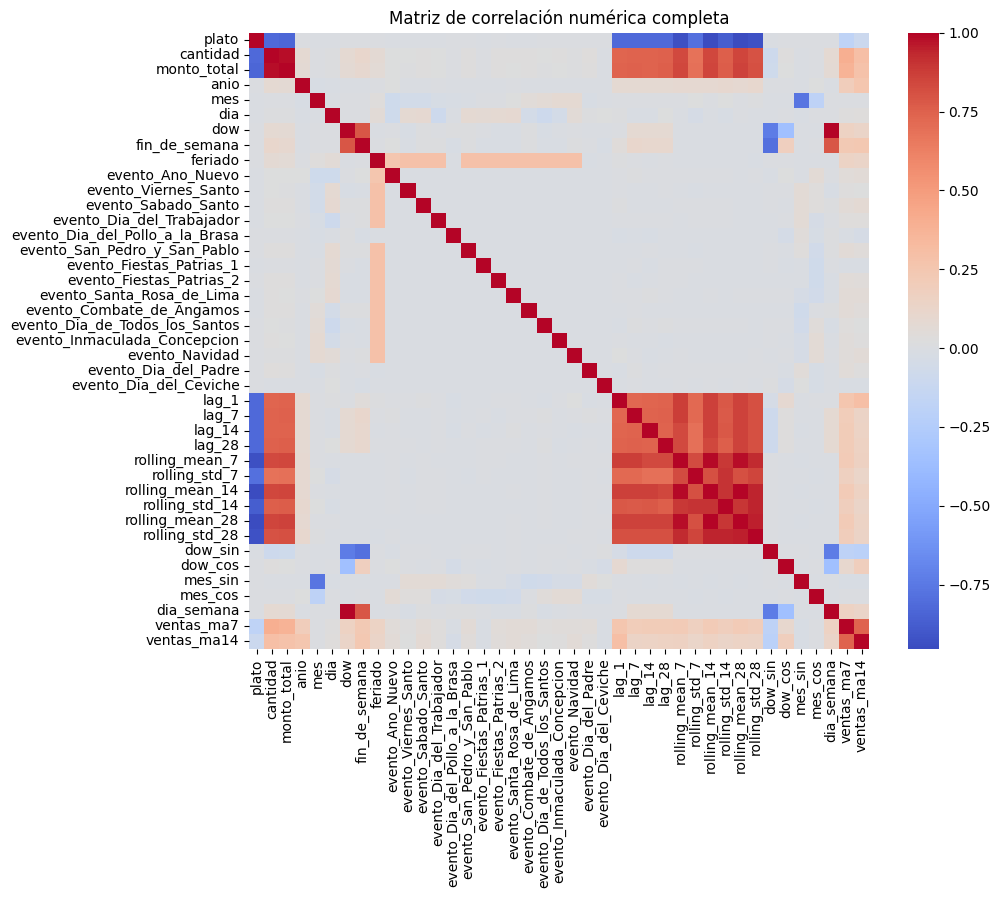

,,0
rolling_mean_14,rolling_mean_28,0.993816
rolling_mean_28,rolling_mean_14,0.993816
rolling_mean_7,rolling_mean_14,0.988502
rolling_mean_14,rolling_mean_7,0.988502
rolling_mean_28,rolling_mean_7,0.982340
rolling_mean_7,rolling_mean_28,0.982340
monto_total,cantidad,0.981310
cantidad,monto_total,0.981310
rolling_mean_28,plato,0.953671
plato,rolling_mean_28,0.953671


In [20]:
# === MATRIZ DE CORRELACIÓN GLOBAL ===
import seaborn as sns
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(num_df.corr(), cmap="coolwarm", annot=False)
plt.title("Matriz de correlación numérica completa")
plt.show()

corr = num_df.corr().abs().unstack().sort_values(ascending=False)
corr = corr[(corr != 1)]  # elimina la diagonal
corr.head(10)

# **Distribución de Ventas**

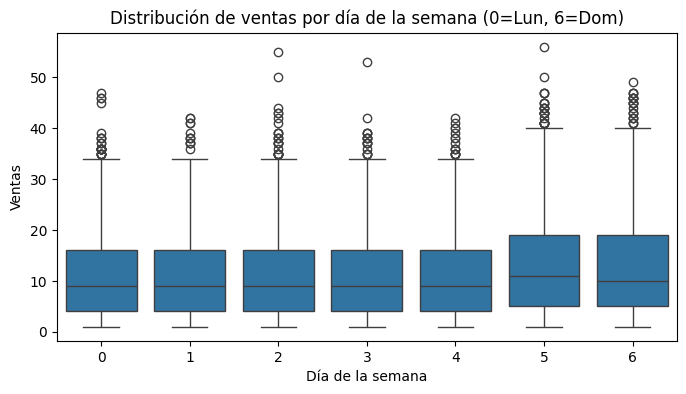

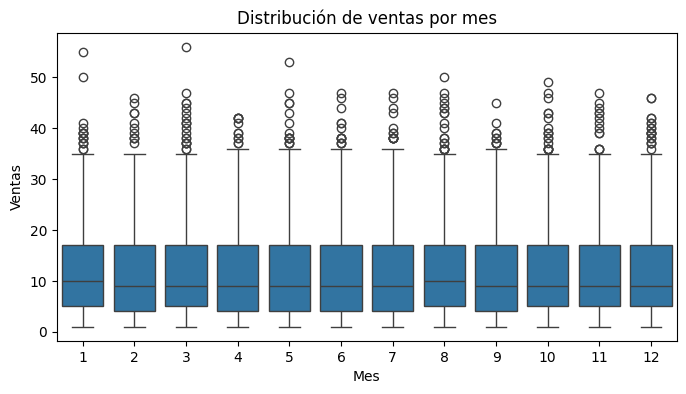

In [21]:
plt.figure(figsize=(8,4))
sns.boxplot(x="dia_semana", y=target_col, data=df)
plt.title("Distribución de ventas por día de la semana (0=Lun, 6=Dom)")
plt.xlabel("Día de la semana"); plt.ylabel("Ventas"); plt.show()

if "mes" in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x="mes", y=target_col, data=df)
    plt.title("Distribución de ventas por mes")
    plt.xlabel("Mes"); plt.ylabel("Ventas"); plt.show()

if "lluvia_flag" in df.columns:
    plt.figure(figsize=(5,4))
    sns.boxplot(x="lluvia_flag", y=target_col, data=df)
    plt.title("Ventas: días con lluvia vs sin lluvia")
    plt.xlabel("Lluvia (0=No, 1=Sí)"); plt.ylabel("Ventas"); plt.show()


## 10) Análisis de clima (si hay columnas disponibles)

In [16]:

if len(climate_cols) > 0:
    # 10.1 Dispersión temperatura vs ventas
    if "temp_avg" in climate_cols:
        ctemp = climate_cols["temp_avg"]
        plt.figure(figsize=(5,4))
        plt.scatter(df[ctemp], df[target_col], alpha=0.6)
        plt.title("Ventas vs Temperatura promedio")
        plt.xlabel(ctemp); plt.ylabel(target_col); plt.show()

    # 10.2 Dispersión precipitación vs ventas
    if "precip_mm" in climate_cols:
        cprec = climate_cols["precip_mm"]
        plt.figure(figsize=(5,4))
        plt.scatter(df[cprec], df[target_col], alpha=0.6)
        plt.title("Ventas vs Precipitación (mm)")
        plt.xlabel(cprec); plt.ylabel(target_col); plt.show()

    # 10.3 Comparación lluvia vs no lluvia
    lluvia_flag = climate_cols.get("lluvia_flag", None)
    if lluvia_flag and lluvia_flag in df.columns:
        # normalizar a 0/1
        lf = pd.to_numeric(df[lluvia_flag], errors="coerce").fillna(0).astype(int)
        grp = df.groupby(lf)[target_col].mean().rename(index={0:"Sin lluvia",1:"Con lluvia"})
        print(grp)
        plt.figure(figsize=(4,3))
        plt.bar(grp.index.astype(str), grp.values)
        plt.title("Ventas promedio: días con lluvia vs sin lluvia"); plt.ylabel("Promedio ventas"); plt.show()
else:
    print("No se detectaron columnas climáticas; omitiendo esta sección.")


No se detectaron columnas climáticas; omitiendo esta sección.


## 11) Medias móviles de ventas (7 y 14 días)

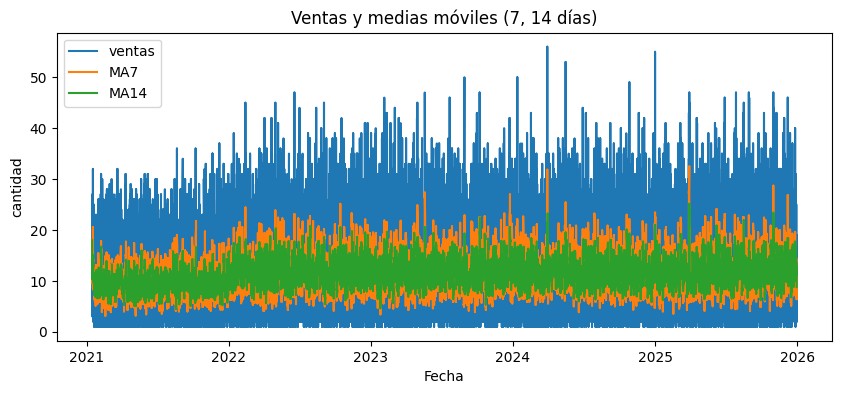

In [17]:

df = df.sort_values(DATE_COL).reset_index(drop=True)
df["ventas_ma7"] = df[target_col].rolling(7, min_periods=1).mean()
df["ventas_ma14"] = df[target_col].rolling(14, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(df[DATE_COL], df[target_col], label="ventas")
plt.plot(df[DATE_COL], df["ventas_ma7"], label="MA7")
plt.plot(df[DATE_COL], df["ventas_ma14"], label="MA14")
plt.title("Ventas y medias móviles (7, 14 días)")
plt.xlabel("Fecha"); plt.ylabel(target_col)
plt.legend(); plt.show()


## 12) Análisis por producto/plato (si existe columna de plato)

Top 5 platos por ventas acumuladas: [1, 2, 4, 3, 5]


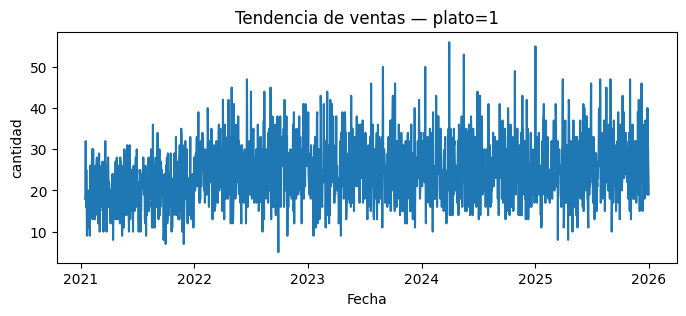

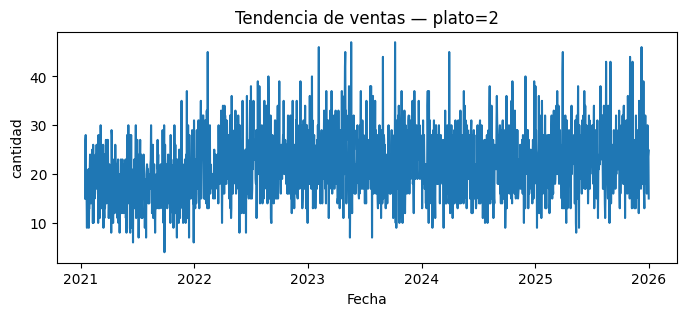

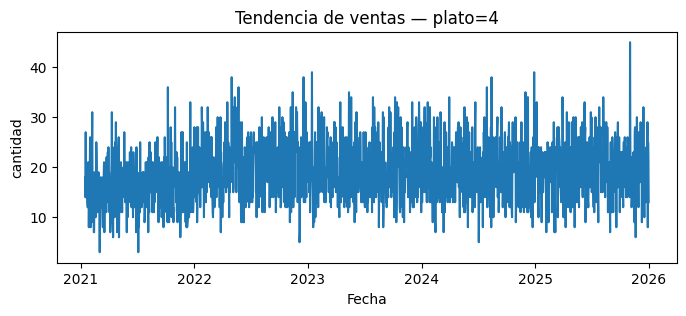

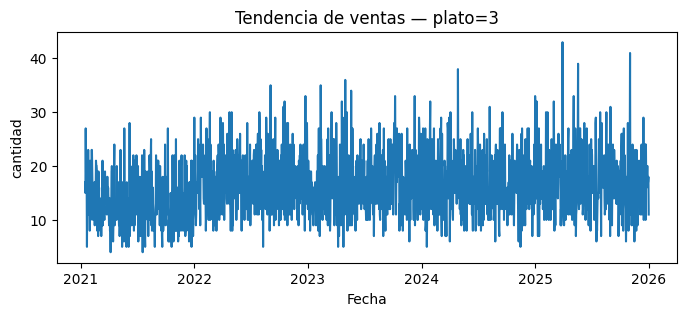

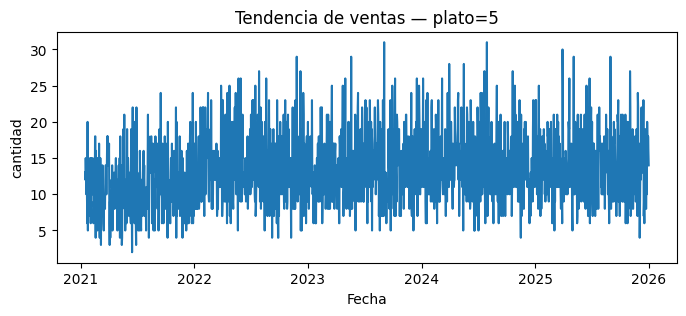

In [18]:

if plato_col and plato_col in df.columns:
    topk = (df.groupby(plato_col)[target_col].sum().sort_values(ascending=False).head(5)).index.tolist()
    print("Top 5 platos por ventas acumuladas:", topk)
    for p in topk:
        sub = df[df[plato_col]==p].sort_values(DATE_COL)
        if len(sub) < 3:
            continue
        plt.figure(figsize=(8,3))
        plt.plot(sub[DATE_COL], sub[target_col])
        plt.title(f"Tendencia de ventas — {plato_col}={p}")
        plt.xlabel("Fecha"); plt.ylabel(target_col); plt.show()
else:
    print("No hay columna de plato; omitiendo análisis por producto.")



## 13) Resumen y próximos pasos

- **Dataset inspeccionado** y alineado a la nueva salida de `preprocesamiento (3)`.
- **Estacionalidad** semanal y mensual verificada con gráficos.
- **Correlaciones** con planificación/feriado y **clima** (si existe), para justificar su uso como regresores exógenos en el modelo.
- **Medias móviles** para validar suavización de la señal base.

**Siguiente** (fuera de este EDA): re-entrenar modelos (SARIMAX/Prophet/XGBoost) usando las columnas exógenas confirmadas aquí.


# **Save in Repository**

In [22]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [ ]:
!git add.
!git commit -m "EDA"